***
<center><h1>Face Rhythm</h1></center>

***

<img src="https://drive.google.com/uc?export=view&id=1wcz_8-cq6MppJ_wkOOu7GkeZkYI3uGB1">

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 
- There are two options for calculating the optic flow (parameters set independently as well), one single-threaded and one multi-threaded. Do parameter tuning on the single-threaded one so you can quit out of it, as well as watch the calculation as it happens with showVideo_pref=1. The multi-threaded one is only faster if you have a lot of cores in your CPU (>10), then it's faster, else stick with the single-threaded version and set showVideo_pref=0.

### The most important parameters:  
***(Consider all of these before you run the code for the first time)***
- Optic flow params:
    - **'spacing'**: ~ 3 to 12. Spacing between dots, in pixels. Inversely related to number of dots to use in the calculation. Try to keep the number of dots below 2000 if possible (eats up memory and computation time). More dots generally means better final results, more robust to outliers and weird stuff. I'd make the spacing as small (more dots) as you can go before you run out of RAM in the final calculations
    - **lk_params 'win_size'**: ~ 25,25 to 80,80. This is the spatial integration window for the optical flow measurement. Try to make it as small as possible without it becoming unstable. The two values are for X and Y length of square integration window. Probably keep the same for most applications
- Outlier removal params:
    - **outlier_threshold_positions**: ~ 20 to 100. If a dot strays more than this many pixels away from its anchor position, its displacement in the dimension it cross the threshold in, for those time points (and some time points around it, see params below), for that dot only, will be set to zero
    - **outlier_threshold_displacements** ~ 5 to 25. Similar to above, but for displacement. Only the outlier time points are removed (no window around outliers considered).
    - **framesHalted_beforeOutlier**: ~ 0 to 30. The number of frames to also remove before detected outlier events. Consider what is causing your outlier event. If it is an arm movement or something, how long does such a movement last? How long before it will cause a dot to move to the outlier threshold?
    - **framesHalted_afterOutlier**: ~ 0 to 10. Simlar to above but for after an outlier event is detected
    - **relaxation_factor** : ~ 0.03 to 0.1. This is the rate of the exponential decay / relaxation / attraction back to the anchor position that a point undergoes. It is meant to prevent baseline drift. Think of it like a high pass on the dot position trace
- Spectral analysis params:
    - **win_len**: ~ 0.1 to 1.0. The length of the time window used for the short-time Fourier transform. Longer gives better spectral resolution, shorter gives better temporal resolution. There are several other parameters that are related but this is the most important. Longer windows (along with decreasing the overlap parameter) also decrease the size of the output spectrograms, which can help with memory and computation time in the subsequent analyses
- TCA:
    - **rank = 6**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors

***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to the folder with all the raw videos. 
The run name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

### Data Organization Assumptions
We assume that you have s Sessions and v Videos per session. For some users, there will only be one video per session. You might have multiple videos per session because either (1) you save your session video in chunks due to your recording software or (2) you have separated your video into _trial_ videos. If your videos correspond to discrete trials, mark the trials option True. If you have a single video per session with a _trial_ structure, you should also provide a _trial_indexes_ file. We'll need this to properly run optic flow on it. 

If your Data Folder contains folder you don't want, you can specify a folder name pattern to restrict the folders considered.

- Data Folder
   - Session Folder 1
      - Video 1
      - ...
      - Video v
      - Optional: trial_indexes
   - ...
   - Session Folder s
      - Video 1
      - ...
      - Video v
      - Optional: trial_indexes 

In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# Import libraries
import cv2

import matplotlib.pyplot as plt
import numpy as np
import torch.cuda

from face_rhythm.util import helpers
from pathlib import Path

# SET THE PROJECT PATH, DATA PATH, and (optionally) run name
project_path     = Path('./').resolve()
video_path       = Path('../../data').resolve()
run_name         = 'new'
overwrite_config = False
remote           = False # cv2 doesn't play nicely with ssh/slurm connections, set true if using that
trials           = True  # Let us know if you're using trials

config_filepath = helpers.setup_project(project_path, video_path, run_name, overwrite_config, remote, trials)

OpenCV version: 4.1.2
Pytorch version: 1.7.0


In [3]:
import types
from pathlib import Path
# IMPORT VIDEOS
# We handle the session_prefix tag cleverly
# If you specify a unique folder, then we'll just load just one folder
# If you specify a folder prefix, then we'll load all sessions that fit that prefix
# If you specify no prefix, then we'll load all sessions

config = helpers.load_config(config_filepath)
config['Video']['session_prefix'] = 'hr047' 
config['Video']['print_filenames'] = True
helpers.save_config(config, config_filepath)

helpers.import_videos(config_filepath)
helpers.get_video_data(config_filepath)
helpers.create_nwbs(config_filepath)

Current Session: hr047
number of videos: 1
number of frames per video (roughly): 86717
number of frames in ALL videos (roughly): 86717

 ['/Users/akshay/Documents/Harvard/face_projects/data/hr047/hr047_fc2_save_2015-07-22-104302-0000.mp4']
Sampling rate pulled from video file metadata:   30.026 frames per second


***
<center><h1>Set ROI</h1></center>

***

### Manually specify your roi

This is good if your animal doesn't fill the view and if you have stationary objects nearby.

<IPython.core.display.Javascript object>


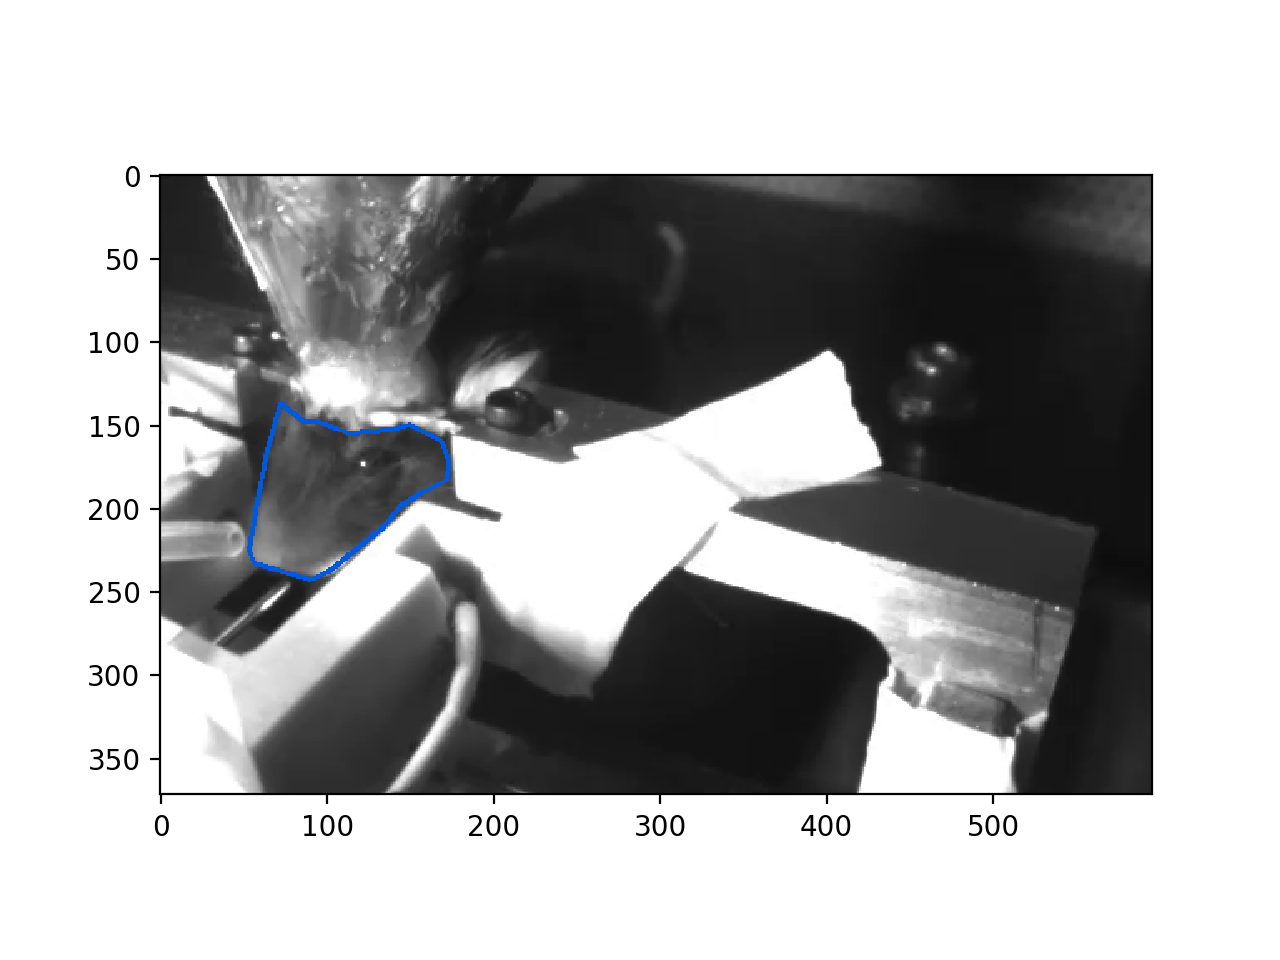

Button(description='Disconnect mpl', style=ButtonStyle())

In [2]:
%matplotlib notebook

from face_rhythm.util import helpers
from face_rhythm.util import set_roi

### Select POLYGON SUBFRAME for DISPLACEMENT Eignfaces
## This block of code will pop up a little GUI. Click around the
## region of the face that you want to include in the analysis.
## When you are done, click the 'Disconnect mpl' button


config = helpers.load_config(config_filepath)
config['ROI']['session_to_set'] = 'hr047'
config['ROI']['vid_to_set'] = 1 # 1 indexed. Sets the video to use to make an image
config['ROI']['frame_to_set'] = 2 # 1 indexed. Sets the frame number to use to make an image
config['ROI']['load_from_file'] = False
helpers.save_config(config, config_filepath)

frame, bbox_selector = set_roi.get_roi(config_filepath)

In [3]:
# Don't run this until you're done selecting
if not config['ROI']['load_from_file']:
    set_roi.process_roi(config_filepath, frame, bbox_selector)

***
<center><h1>Run Optic Flow</h1></center>

***

### Run as either single- or multi-threaded depending on run time and number of dots

Multithread is generally 2X to many-X faster, but may fail when too many dots are selected (memory overload)

*If show video set to true on a remote connection, the video won't show, but it will save to the proj folder.*

In [ ]:
from face_rhythm.optic_flow import optic_flow

### == PREFERENCES ==

config = helpers.load_config(config_filepath)

config['Optic']['vidNums_toUse'] = [0]
config['Optic']['spacing'] = 8  ## This is the distance between points in the grid (both in x and y dims)

config['Optic']['showVideo_pref'] = True  ## much faster when video is off. If 'remote' option chosen (from first cell block), video will be saved as file in project folder.
config['Optic']['test_len'] = 10 # used only for remote users when showVideo_pref==True
config['Optic']['dot_size'] = 1  ## for viewing purposes

## below will print the fps ever 'fps_counterPeriod' . Useful for checking the approximate speed of import.
## Best to turn off when doing a full run. (this is mostly for optimizing and debugging)
config['Optic']['printFPS_pref'] = False
config['Optic']['fps_counterPeriod'] = 10 ## number of frames to do a tic toc over

## Parameters for lucas kanade optical flow
## win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
## max level: only moderate effects if everything working properly. Keep around 3.
## criteria values have to do with the search algorithm. For speed: EPS small, COUNT big.
config['Optic']['lk'] = {}
config['Optic']['lk']['winSize']     = (30,30)
config['Optic']['lk']['maxLevel']    = 4
config['Optic']['lk']['criteria']    = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.001)

config['Optic']['recursive'] = True
config['Optic']['relaxation_factor'] = 0.001
config['Optic']['multithread'] = False 

helpers.save_config(config, config_filepath)


### == CALCULATION ==

optic_flow.optic_workflow(config_filepath)

***
<center><h1>Clean Optic Flow</h1></center>

***

### Clean up displacements traces and make good positions traces

Check the parameters here, they are essential for getting good results

In [ ]:
%matplotlib inline

from face_rhythm.optic_flow import clean_results

## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well

config = helpers.load_config(config_filepath)
config['outlier_threshold_positions'] = 30 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
config['outlier_threshold_displacements'] = 4 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
config['framesHalted_beforeOutlier'] = 20 # in frames. best to make even
config['framesHalted_afterOutlier'] = 4 # in frames. best to make even
config['relaxation_factor'] = 0.001 # This is the speed at which the integrated position exponentially relaxes back to its anchored position. Make ~0.005 to 0.05 for face video at 120 Hz
config['pixelNum_toPlot'] = 10
helpers.save_config(config, config_filepath)

clean_results.clean_workflow(config_filepath)

***
<center><h1>Convolutional Dimensionality Reduction</h1></center>

***

### Do some denoising and to get the number of dots down to a managable number

In particular, it is nice for the batched CP decomposition later that the batches can be as big as possible in the temporal dimension, so doing some mild convolutional dim reduction first is helpful.

In [ ]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

from face_rhythm.optic_flow import conv_dim_reduce

config = helpers.load_config(config_filepath)

pointInds_toUse = helpers.load_data(config_filepath, 'path_pointInds_toUse')

# Create kernel
config['cdr_width_cosKernel'] = 12 # This is the radius of a 2-dimensional cosine kernel. If you get an error about SVD not working, probably increase this
config['cdr_num_dots'] = pointInds_toUse.shape[0]

# Distance between points in the grid
config['cdr_spacing'] = 8 

# For displaying dots
config['cdr_vidNum'] = 0 # 0 indexed
config['cdr_frameNum'] = 0 # 0 indexed
config['cdr_dot_size'] = 1

# Coefficients of influence 
config['cdr_num_components'] = 4
helpers.save_config(config, config_filepath)

conv_dim_reduce.conv_dim_reduce_workflow(config_filepath)

### Display or Save video of dots

In [ ]:
# conv_dim_reduceim_reduce.display_displacements(config_filepath , )

***
<center><h1>Analysis</h1></center>

***

### Decompose and Analyze the Data in different ways

Below you'll find the following:
- PCA done on raw positions
- Spectral analysis of every pixels to transoform the basis to be oscillatory
- TCA done on the spectra
- A lonely t-SNE plot of the temporal factors

### PCA
The X and Y displacements are concatenated and run together. Something interesting to try would be to transform to polar coordinates, concatenate and run that way. Maybe TCA on the positions with magnitude vs angle being one of the dimensions would make sense.

In [ ]:
from face_rhythm.analysis import pca

%matplotlib notebook
%matplotlib notebook
pca.pca_workflow(config_filepath, 'positions_absolute')

### Positional TCA

In [ ]:
from face_rhythm.analysis import tca

%matplotlib inline

### Prepare Tensorly
# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.

config = helpers.load_config(config_filepath)
config['tca_pref_useGPU'] = False

if config['tca_pref_useGPU']:
    cuda_device_number = torch.cuda.current_device()
    print(f"using CUDA device: 'cuda:{cuda_device_number}'")
    device = f'cuda:{cuda_device_number}'
else:
    print(f"using CPU")
    device = 'cpu'  

config['tca_device'] = device
config['tca_rank'] = 4
config['tca_init'] = 'random'
config['tca_vid_display'] = False
config['tca_vid_save'] = True
positional_path = project_path / 'viz' / 'positional'
positional_path.mkdir(parents=True, exist_ok=True)
config['tca_vid_dir'] = str(positional_path)
config['tca_verbosity'] = 0
config['tca_n_iters'] = 100
config['tca_display_frames'] = 100
helpers.save_config(config, config_filepath)

tca.positional_tca_workflow(config_filepath, 'positions','positions_absolute') # you can use differe positions data

### Spectral Analysis
I've played with a few different methods. While multiresolution methods seems ideal for this use-case, It just ends up severly overrepresenting low frequency factors, making noisier high frequency factors, and doing an overall worse job at reconstruction.
A good ol' multitaper short time fourier transform seems to work fine. Adding in raw positions to subsequent dimensionality reduction later on seems like a natural thing to do, as single resolution spectral analysis ends up kind of ignoring slower dynamics.

In [ ]:
### Prepare Tensorly
# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.

config = helpers.load_config(config_filepath)

eps = 1.19209e-07 # float32 epsilon

hop_length = 16
fmin_rough = 2
Fs = config['vid_Fs']
sr = Fs
n_bins = 50
bins_per_octave = int(np.round((n_bins) / np.log2( (Fs/2)/fmin_rough )))
fmin = ( (Fs/2)/(2**((n_bins)/bins_per_octave)) ) - (2*eps)
fmax = fmin*(2**((n_bins)/bins_per_octave))

freqs_Sxx = fmin*(2**((np.arange(n_bins)+1)/bins_per_octave))

print(f'bins_per_octave: {round(bins_per_octave)} bins/octave')
print(f'minimum frequency (fmin): {round(fmin,3)} Hz')
print(f'maximum frequency (fmax): {round(fmax,8)} Hz')
print(f'Nyquist                 : {sr/2} Hz')
print(f'number of frequencies:    {n_bins} bins')
plt.figure()
plt.plot(freqs_Sxx)
print(f'Frequencies: {np.round(freqs_Sxx , 3)}')

In [ ]:
from face_rhythm.analysis import spectral_analysis

### Parameters for multitaper short-time Fourier transform

config = helpers.load_config(config_filepath)
config['cqt_hop_length'] = hop_length
config['cqt_sr'] = sr
config['cqt_n_bins'] = n_bins
config['cqt_bins_per_octave'] = bins_per_octave
config['cqt_fmin'] = fmin
config['cqt_fmin_rough'] = fmin_rough
config['cqt_fmax'] = fmax
helpers.save_config(config, config_filepath)

helpers.save_data(config_filepath, 'freqs_Sxx', freqs_Sxx)

# CQT spectrogram for every pixel
# this code was previously parallelized, 
# but it's pretty quick compared to the other steps, 
# so might as well keep it simple

spectral_analysis.cqt_all(config_filepath, 'positions')

In [ ]:
from face_rhythm.analysis import spectral_analysis

# Positional CQT

config = helpers.load_config(config_filepath)
config['cqt_hop_length'] = 8
helpers.save_config(config, config_filepath)

spectral_analysis.cqt_positions(config_filepath)

### TCA
There are two major tensor packages, one is tensortools (made by an acquaintance named Alex Williams) and the other is Tensorly.
Tensorly seems to be more packaged up and has some options to use some advanced backends like torch, tf, and mxnet. Though there are
a couple of nice features in tensortools that Tensorly doesn't have, though. Generally tensortools gives better reconstructions, but takes
much longer to do it.

This function also spits out a ton of plots, consult Rich or Akshay for interpretation.

In [ ]:
from face_rhythm.analysis import tca

%matplotlib inline

config = helpers.load_config(config_filepath)

### Prepare Tensorly

# If the input is small ( < half the size of your GPU memory) and you have CUDA, set to 'gpu'. It's super fast.

config['tca_pref_useGPU'] = True

if config['tca_pref_useGPU']:
    cuda_device_number = torch.cuda.current_device()
    print(f"using CUDA device: 'cuda:{cuda_device_number}'")
    device = f'cuda:{cuda_device_number}'
else:
    print(f"using CPU")
    device = 'cpu'  

config['tca_device'] = device
config['tca_rank'] = 8
config['tca_vid_display'] = True
config['tca_vid_save'] = True
path_frequential = project_path / 'viz' / 'frequential'
path_frequential.mkdir(parents=True, exist_ok=True)
config['tca_vid_dir'] = str(path_frequential)
config['tca_verbosity'] = 1
config['tca_n_iters'] = 100
config['tca_display_frames'] = 500
helpers.save_config(config, config_filepath)

tca.full_tca_workflow(config_filepath, 'positions_absolute')

## Outputs:
Below is the output tree structure of the NWB file

In [ ]:
helpers.dump_nwb(config_filepath)

## Example of how to access NWB output data

In [ ]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np

config = helpers.load_config(config_filepath)
nwb_path = config['path_nwb']
io = pynwb.NWBHDF5IO(nwb_path, 'r')
nwbfile = io.read()

example_data = nwbfile.processing['Face Rhythm']['Optic Flow']['positions'].data

plt.figure()
plt.plot(example_data[:,0,0])

## Example of how to access parameters

In [ ]:
config = helpers.load_config(config_filepath)
print(config['lk_winSize'])